# Wind Effects

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table

In [54]:
import desietc.gfa

In [3]:
!mv ~/Downloads/shear.csv .

In [4]:
T = astropy.table.Table.read('shear.csv')

In [17]:
len(T)

697

In [49]:
CS5 = array([
       [[ 1.04037829e+02, -3.84919432e+02],
        [ 1.42573799e-02,  4.66981235e-03],
        [-4.65492774e-03,  1.41892856e-02]],
       [[ 3.98099678e+02, -1.99229500e+01],
        [ 4.31199163e-05,  1.50010651e-02],
        [-1.49338639e-02,  3.37050638e-05]],
       [[ 3.33616631e+02,  2.18077290e+02],
        [-8.86064348e-03,  1.21055081e-02],
        [-1.20477346e-02, -8.82590456e-03]],
       [[-1.04092446e+02,  3.84772634e+02],
        [-1.42618407e-02, -4.65682022e-03],
        [ 4.64286359e-03, -1.41935916e-02]],
       [[-3.98127583e+02,  2.00975746e+01],
        [-1.00846756e-05, -1.50027231e-02],
        [ 1.49362446e-02, -1.36688550e-06]],
       [[-3.34189142e+02, -2.17879544e+02],
        [ 8.75839914e-03, -1.21795768e-02],
        [ 1.21237342e-02,  8.72473620e-03]]])

GUIDE0 [ 104.037829 -384.919432] [ 133.22268566 -375.36032612]
GUIDE2 [398.099678 -19.92295 ] [398.18794447  10.78423026]
GUIDE3 [333.616631 218.07729 ] [315.4788938  242.85726508]
GUIDE5 [-104.092446  384.772634] [-133.28643391  375.24012301]
GUIDE7 [-398.127583    20.0975746] [-398.14822633  -10.61299959]
GUIDE8 [-334.189142 -217.879544] [-316.26069896 -242.81113771]


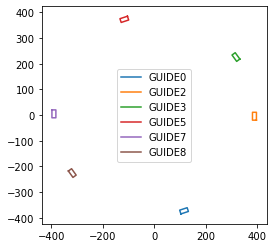

In [67]:
def plot_cs5(CS5=CS5):
    y, x = 2 * desietc.gfa.GFACamera.nampy - 1, 2 * desietc.gfa.GFACamera.nampx - 1
    corners = np.array([
        [1, 0, 0],
        [1, x, 0],
        [1, x, y],
        [1, 0, y]])
    corners = np.sum(CS5.reshape(6, 1, 3, 2) * corners.reshape(4, 3, 1), axis=2)
    ax = plt.gca()
    for i, name in enumerate(desietc.gfa.GFACamera.guide_names):
        (xy1, xy2, xy3, xy4) = corners[i]
        print(name, xy1, xy2)
        ax.plot(*np.transpose([xy1, xy2, xy3, xy4, xy1]), '-', label=name)
    plt.legend()
    ax.set_aspect(1)

plot_cs5()

In [81]:
offsets = np.array([np.rad2deg(np.arctan2(G[1,1], G[1,0])) for G in CS5])
offsets

array([  18.13551027,   89.8353062 ,  126.20231422, -161.91694436,
        -90.03851363,  -54.27988513])

In [82]:
A = np.array(T[['A0','A2','A3','A5','A7','A8']]).view(np.float).reshape(6, -1)
B = np.array(T[['B0','B2','B3','B5','B7','B8']]).view(np.float).reshape(6, -1)
BETA = np.array(T[['BETA0','BETA2','BETA3','BETA5','BETA7','BETA8']]).view(np.float).reshape(6, -1) + offsets.reshape(6, 1)

In [89]:
X = np.cos(np.deg2rad(BETA))
Y = np.sin(np.deg2rad(BETA))

In [90]:
missing = (A==0)
A[missing] = np.nan
B[missing] = np.nan
X[missing] = np.nan
Y[missing] = np.nan

In [91]:
A2 = np.nanmedian(A, axis=0)
B2 = np.nanmedian(B, axis=0)
X2 = np.nanmedian(X, axis=0)
Y2 = np.nanmedian(Y, axis=0)

In [92]:
BETA2 = np.rad2deg(np.arctan2(Y2, X2))

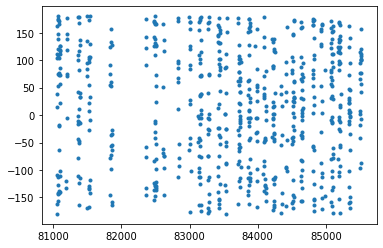

In [93]:
plt.plot(T['EXPID'], BETA2, '.');

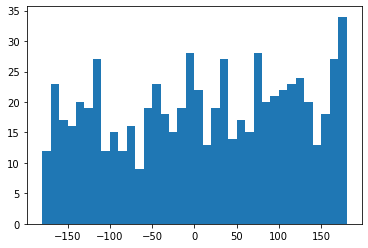

In [95]:
plt.hist(BETA2, bins=np.linspace(-180, 180, 37));

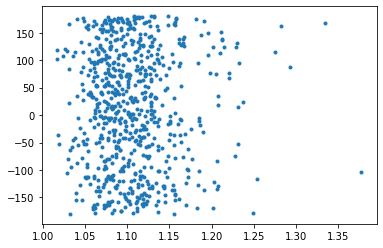

In [97]:
plt.plot(ELLIP, BETA2, '.');

In [34]:
ELLIP = A2 / B2
SIZE = np.sqrt(A2 * B2)

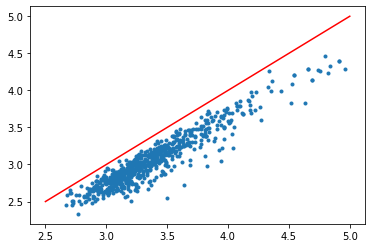

In [35]:
plt.plot(A2, B2, '.');
plt.plot([2.5,5],[2.5,5], 'r-')

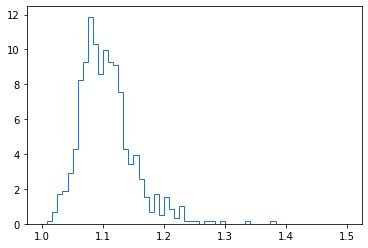

In [36]:
plt.hist(ELLIP, bins=np.linspace(1,1.5,61), density=True, histtype='step');

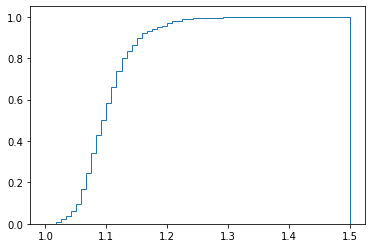

In [37]:
plt.hist(ELLIP, bins=np.linspace(1,1.5,61), cumulative=True, density=True, histtype='step');

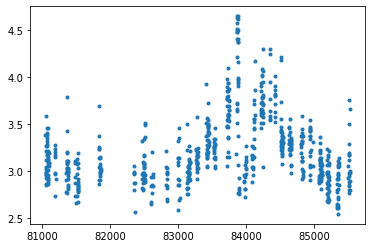

In [38]:
plt.plot(T['EXPID'], SIZE, '.')

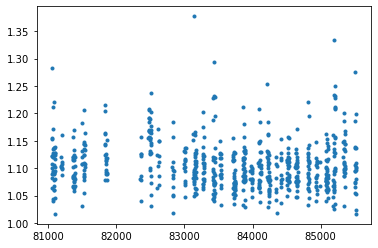

In [39]:
plt.plot(T['EXPID'], ELLIP, '.')

sigma in pixels -> sigma in arcsecs -> FWHM in arcsecs

In [43]:
conv = 0.2 * 2.355 / np.sqrt(2)

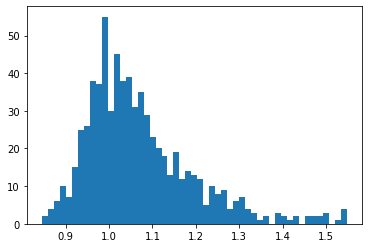

In [44]:
plt.hist(SIZE*conv, bins=51);

In [45]:
np.median(SIZE*conv)

1.0440574059081678

(0.1, 0.52)

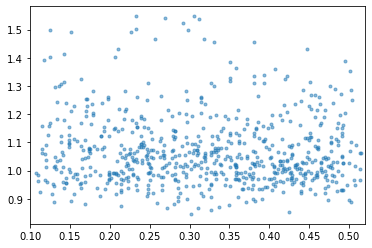

In [47]:
plt.plot(np.fmod(T['MJD'], 1), SIZE*conv, '.', alpha=0.5)
plt.xlim(0.1,0.52)

Fractional decrease over the night: -4.0%


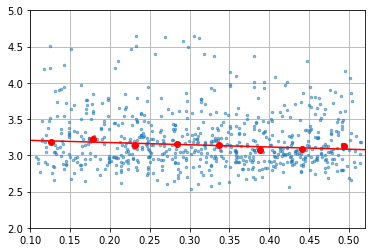

In [48]:
def trend(T=T, nbins=8):
    size = SIZE
    time = np.fmod(T['MJD'], 1)
    bins = np.linspace(0.1, 0.52, nbins+1)
    idx = np.digitize(time, bins) - 1
    plt.plot(time, size, '.', ms=5, alpha=0.5)
    plt.xlim(bins[0], bins[-1])
    plt.ylim(2, 5)
    meds = np.empty(nbins)
    for i in range(nbins):
        sel = idx == i
        meds[i] = np.median(size[sel])
    ctr = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(ctr, meds, 'ro')
    plt.grid()
    slope, offset = np.polyfit(ctr, meds, deg=1)
    yline = offset + slope * bins
    plt.plot(bins, yline, 'r-')
    frac_change = (yline[-1] - yline[0]) / yline[0]
    print(f'Fractional decrease over the night: {1e2*frac_change:.1f}%')

trend()